In [25]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

import re
import string
import nltk
from nltk.corpus import stopwords


import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [26]:
# for plotting graphs and visualization
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from wordcloud import WordCloud

In [27]:
df=pd.read_csv('cleaned_reviews.csv')
train = df.sample(frac = 0.7)
test = df.drop(train.index)



In [28]:
train.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
8275,positive,i use this at work it great everyone asks me a...,24,5.0
10178,negative,it literally barely works no one on discord ca...,24,3.0
16716,positive,plain and simple this is good quality loud and...,97,5.0
8938,neutral,even with the dongle in clear line of sight th...,29,1.0
12947,neutral,for gaming,2,5.0


In [29]:
## EDA

In [30]:
train.describe()

,cleaned_review_length,review_score
count,12138.000000,12138.000000
mean,30.281265,3.631570
std,35.636086,1.678501
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


In [31]:
test.describe()

,cleaned_review_length,review_score
count,5202.000000,5202.000000
mean,30.345252,3.689927
std,36.303374,1.661214
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,537.000000,5.000000


The columns:

- `review_score`: review score positive will have 5
- `cleaned_review`: Text of review
- `cleaned_review_length`: Polarity of the tweet
- `sentiments`: Sentiment of product

## General EDA

### Missing values
Checking if there are missing values in the data. 

In [32]:
train.isnull().sum()

sentiments               0
cleaned_review           2
cleaned_review_length    0
review_score             0
dtype: int64

In [33]:
test.isnull().sum()

sentiments               0
cleaned_review           1
cleaned_review_length    0
review_score             0
dtype: int64

In [34]:
# dropping the missing values
train.dropna(axis=0, how='any', inplace=True)

In [35]:
temp = train.groupby('sentiments').count()['cleaned_review'].reset_index().sort_values(by='cleaned_review',ascending=False)
print(temp)

  sentiments  cleaned_review
2   positive            6629
1    neutral            4431
0   negative            1076


In [36]:
print(f"Train sentiment: \n{(train['sentiments'].value_counts(normalize=True)) * 100}")
print(f"\n")
print(f"Test sentiment: \n{(test['sentiments'].value_counts(normalize=True)) * 100}")

Train sentiment: 
positive    54.622610
neutral     36.511206
negative     8.866183
Name: sentiments, dtype: float64


Test sentiment: 
positive    55.247982
neutral     35.947712
negative     8.804306
Name: sentiments, dtype: float64


In [37]:
train['sentiments'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

In [38]:
test['sentiments'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='black',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

# Text Data Processing 

We will pre-process our data to make it into consistent format. 

- Make texts lowercase
- Remove hyperlinks and punctuations
- Remover numbers
- Tokenizes
- Remove stopwords

In [39]:
def clean_text(text):
    """
    Removes:
        - Texts in square brackets
        - Links
        - Punctuations
        - Words containing numbers

    Makes texts lowercase
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [40]:
def text_preprocessing(text):
    """
    - Tokenizes
    - Remove stopwords 
    - Clean text
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punctuation = clean_text(text)
    
    tokenized_text = tokenizer.tokenize(no_punctuation)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

In [41]:
train['cleaned_review'] = train['cleaned_review'].apply(str).apply(lambda x : text_preprocessing(x))

train.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
8275,positive,use work great everyone asks keyboard time adh...,24,5.0
10178,negative,literally barely works one discord hear anythi...,24,3.0
16716,positive,plain simple good quality loud portable blueto...,97,5.0
8938,neutral,even dongle clear line sight keyboard constant...,29,1.0
12947,neutral,gaming,2,5.0


In [42]:
# Similarly, for test data
test['cleaned_review'] = test['cleaned_review'].apply(str).apply(lambda x : text_preprocessing(x))

test.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
4,neutral,like color size days return period hold charge,21,1.0
5,positive,overall love mouse size weight clicking fabulo...,68,3.0
6,neutral,stopped working,3,1.0
7,positive,son uses school issued chromebook school work ...,170,1.0
9,negative,spent money get quality product thing stopped ...,17,1.0


# Text Statistics
We will analyze our texts:
- Text length analysis
- Word frequency analysis

Adding `text_length` and `text_word_count` columns for our analysis

In [43]:
train['text_length'] = train['cleaned_review'].astype(str).apply(len) # counts the spaces as well
train['text_word_count'] = train['cleaned_review'].apply(lambda x : len(str(x).split()))

In [44]:
# 3 different dataframes for our sentiment
positive = train[train['sentiments'] == 'positive']
negative = train[train['sentiments'] == 'negative']
neutral = train[train['sentiments'] == 'neutral']

## Sentence length analysis

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.

In [45]:
positive['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Positive Text Length Distribution')

negative['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

Relationship of text length with the sentiment

In [46]:
trace0 = go.Box(
    y=positive['text_length'],
    name = 'Positive Text',
    marker = dict(
        color = 'green',
    )
)

trace1 = go.Box(
    y=negative['text_length'],
    name = 'Negative Text',
    marker = dict(
        color = 'red',
    )
)

trace2 = go.Box(
    y=neutral['text_length'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")


# Ngram exploration


N-grams are used to describe the number of words used as observation points
- unigram means singly-worded
- bigram means 2-worded phrase
- trigram means 3-worded phrase

![N-gram](https://i.stack.imgur.com/8ARA1.png)

In [47]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [48]:
## top unigram 
positive_unigrams = get_top_n_words(positive['cleaned_review'], 20)
positive_unigrams

[('great', 2893),
 ('mouse', 2459),
 ('sound', 1625),
 ('love', 1592),
 ('good', 1499),
 ('use', 1431),
 ('like', 1194),
 ('quality', 1089),
 ('works', 1034),
 ('charge', 971),
 ('really', 870),
 ('work', 849),
 ('speaker', 834),
 ('keyboard', 808),
 ('battery', 748),
 ('lights', 713),
 ('price', 705),
 ('easy', 683),
 ('gaming', 659),
 ('nice', 655)]

In [49]:
negative_unigrams = get_top_n_words(negative['cleaned_review'], 20)
neutral_unigrams = get_top_n_words(neutral['cleaned_review'], 20)

In [50]:
df1 = pd.DataFrame(positive_unigrams, columns = ['cleaned_review' , 'count'])
df1.groupby('cleaned_review').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Unigrams in positve text',orientation='h')

In [51]:
df1 = pd.DataFrame(neutral_unigrams, columns = ['cleaned_review' , 'count'])
df1.groupby('cleaned_review').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='orange', title='Top 20 Unigrams in neutral text',orientation='h')

In [52]:
df1 = pd.DataFrame(negative_unigrams, columns = ['cleaned_review' , 'count'])
df1.groupby('cleaned_review').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in negative text',orientation='h')

In [53]:
positive_text = train[train['sentiments'] == 'positive']['cleaned_review']
negative_text = train[train['sentiments'] == 'negative']['cleaned_review']
neutral_text = train[train['sentiments'] == 'neutral']['cleaned_review']

# pre-processed selected text column
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

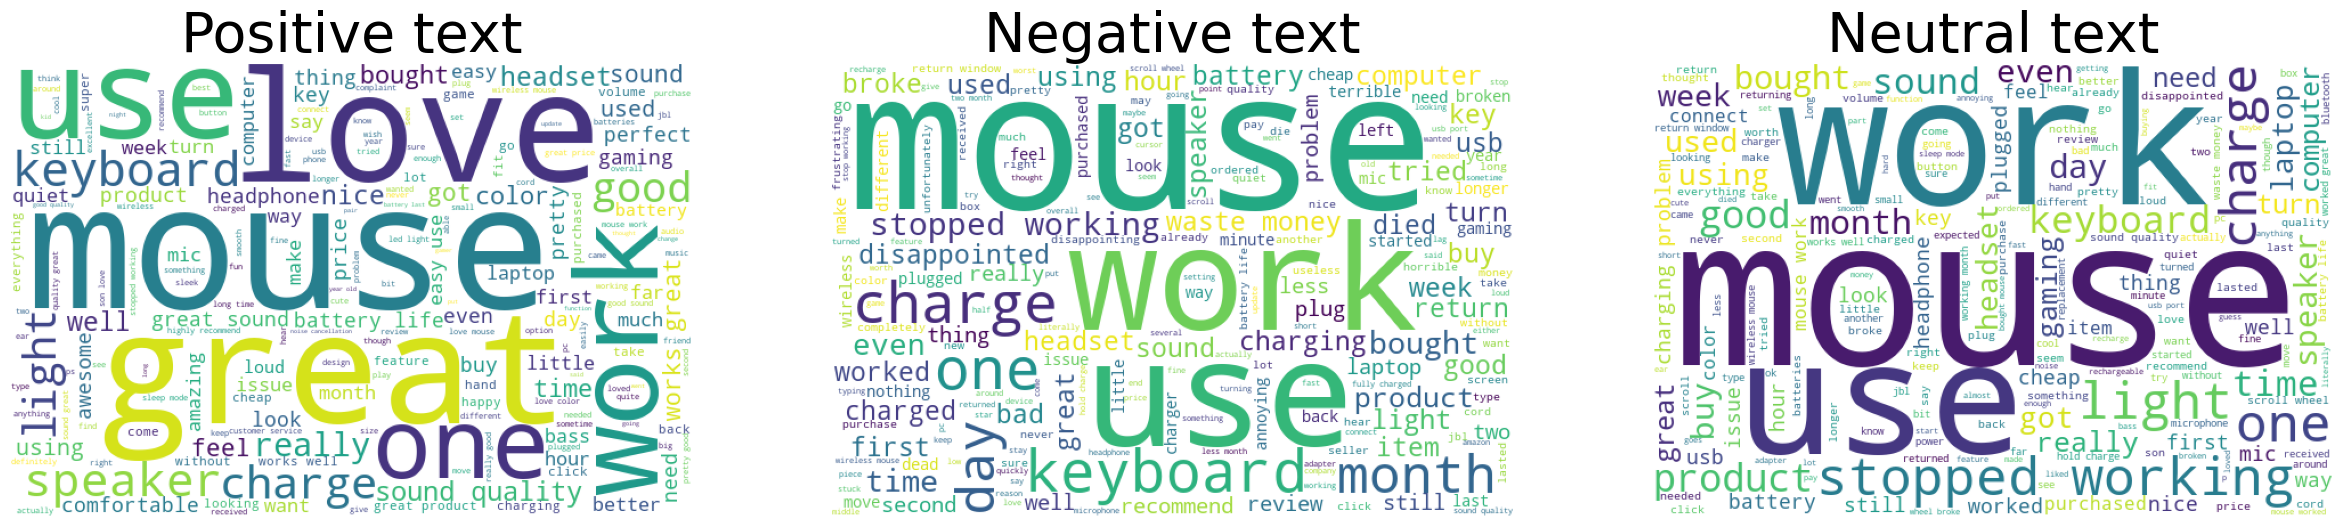

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);

### Feature important 
we have only one feature out here so computation of feature importants does not make much sence. 

In [55]:
def encode_class(text):
    if text=="positive":
        return int(1)
    elif text =="negative":
        return int(0)
    else:
        return int(2)

In [56]:
#train=train[train["sentiment"]!="neutral"]
train["sentiments"]= train["sentiments"].apply(lambda x: encode_class(x)  )
test["sentiments"]= test["sentiments"].apply(lambda x: encode_class(x) )


In [57]:
train.sentiments.value_counts()

1    6629
2    4431
0    1076
Name: sentiments, dtype: int64

In [58]:
sentences_train= train["cleaned_review"].values
sentences_test=test["cleaned_review"].values
y_train=train["sentiments"].values
y_test=test["sentiments"].values

In [59]:
train.head()

,sentiments,cleaned_review,cleaned_review_length,review_score,text_length,text_word_count
8275,1,use work great everyone asks keyboard time adh...,24,5.0,68,11
10178,0,literally barely works one discord hear anythi...,24,3.0,88,14
16716,1,plain simple good quality loud portable blueto...,97,5.0,272,42
8938,2,even dongle clear line sight keyboard constant...,29,1.0,97,15
12947,2,gaming,2,5.0,6,1


For a project, you repository/folder should contain the following:

* `README.md` with
  * Description of the problem
  * Instructions on how to run the project
* Data
  * You should either commit the dataset you used or have clear instructions how to download the dataset
* Notebook (suggested name - `notebook.ipynb`) with
  * Data preparation and data clearning
  * EDA, feature importance analysis
  * Model selection process and parameter tuning
* Script `train.py` (suggested name)
  * Training the final model
  * Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
* Script `predict.py` (suggested name)
  * Loading the model
  * Serving it via a web serice (with Flask or specialized sofware - BentoML, KServe, etc)
* Files with dependencies
  * `Pipenv` and `Pipenv.lock` if you use Pipenv
  * `bentofile.yaml` if you use BentoML
  * or equivalents: conda environment file, requirements.txt or pyproject.toml
* `Dockerfile` for running the service
* Deployment
  * URL to the service you deployed or
  * Video or image of how you interact with the deployed service

####  Model selection 
Going with default hyparameter setting. list of training algorithm
-   logistic regresssion
-   Decision Tree
-   Random Forest
-   SVM 
-   CNN model


In [60]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [45]:
## logistic regresssion
classifier = LogisticRegression(multi_class='multinomial',class_weight='balanced', solver='lbfgs',max_iter=200)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8546712802768166


In [46]:
## Decision Tree
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.829680891964629


In [47]:
## Random Forest
classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8637062668204537


In [49]:
## CNN model

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

worked fine first two weeks stops playing music randomly puase music music phone still going hear anything press play speaker dropped even exposed water even though water proof
[41, 100, 44, 64, 81, 478, 274, 160, 500, 160, 160, 202, 51, 157, 78, 260, 484, 164, 19, 427, 30, 2257, 455, 30, 172, 455, 908]


In [50]:
from keras.utils import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [51]:

y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)

In [52]:
embedding_dim = 100

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation="sigmoid"))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          823200    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 888,651
Trainable params: 888,651
Non-trainable params: 0
__________________________________________________

2023-01-19 09:25:43.487559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Epoch 1/10
1214/1214 [==============================] - 12s 9ms/step - loss: 0.5877 - accuracy: 0.7526 - val_loss: 0.4231 - val_accuracy: 0.8299
Epoch 2/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.3060 - accuracy: 0.8869 - val_loss: 0.4011 - val_accuracy: 0.8443
Epoch 3/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.1623 - accuracy: 0.9472 - val_loss: 0.4306 - val_accuracy: 0.8639
Epoch 4/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.0766 - accuracy: 0.9775 - val_loss: 0.4790 - val_accuracy: 0.8745
Epoch 5/10
1214/1214 [==============================] - 10s 8ms/step - loss: 0.0362 - accuracy: 0.9903 - val_loss: 0.5313 - val_accuracy: 0.8768
Epoch 6/10
1214/1214 [==============================] - 10s 9ms/step - loss: 0.0213 - accuracy: 0.9939 - val_loss: 0.6725 - val_accuracy: 0.8745
Epoch 7/10
1214/1214 [==============================] - 11s 9ms/step - loss: 0.0164 - accuracy: 0.9944 - val_loss: 0.7453 - val_ac

In [54]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9990
Testing Accuracy:  0.8666


## Model Selection & Hyparameter tunning 
-   Algorithm              -------> Accuracy
-   Logistic regresssion   -------> 0.8546
-   Decision Tree          -------> 0.8296
-   Random Forest          -------> 0.8637
-   CNN model              -------> 0.8666

We are going to select one model out of above. i have selected randomforest for fruther hyperparameter tunning and build final model for serving with RestAPI.


In [61]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)

        accuracy = rf.score(X_test, y_test)

        scores.append((d, n, accuracy))

In [62]:
columns = ['max_depth', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

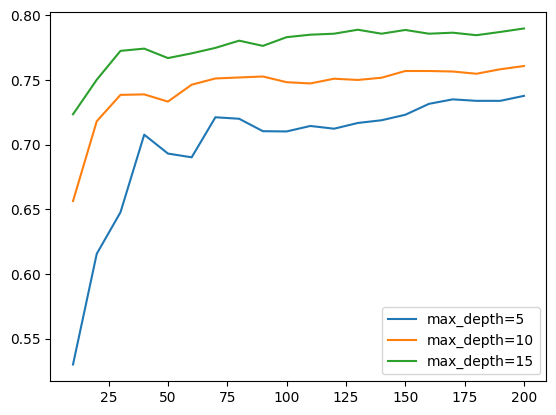

In [63]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             label='max_depth=%d' % d)

plt.legend()

In [64]:
## accuracy best at max_depth == 15
max_depth = 15

In [65]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)
        accuracy = rf.score(X_test, y_test)
        scores.append((s, n, accuracy))

In [66]:
columns = ['min_samples_leaf', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

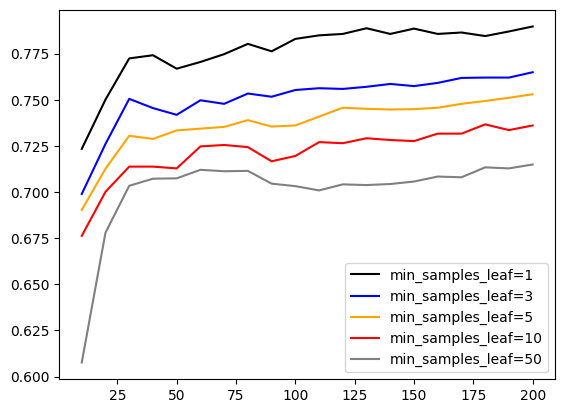

In [67]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [68]:
## accuracy best at min_samples_leaf=1 with above graph
min_samples_leaf = 1

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       random_state=1)